In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import IPython.display as ipd
from IPython.core.display import display
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input

In [2]:
train_mfcc_spec_normalised = np.load('../input/esc-50-cip-project-sound/train_mfcc_spec_normalised.npy',allow_pickle=True)

In [3]:
train_mfcc_spec_normalised[0][0].shape

(20, 216, 1)

In [4]:
x_train_mfcc = np.zeros((1,20,216))
for i in tqdm(range(3799)):
    x_train_mfcc = np.append(x_train_mfcc,[train_mfcc_spec_normalised[i][0][:,:,-1]],axis=0)

100%|██████████| 3799/3799 [01:31<00:00, 41.32it/s]


In [5]:
x_train_mfcc = x_train_mfcc[1:,:,:]

In [6]:
x_train_mfcc = x_train_mfcc[:,:,:,np.newaxis]

In [7]:
y_train_mfcc = []
for i in range(3799):
    y_train_mfcc.append(train_mfcc_spec_normalised[i][1])

In [8]:
y_train_mfcc = np.array(y_train_mfcc)

In [9]:
y_train_mfcc = y_train_mfcc.reshape(3799,1)
y_train_mfcc.shape

(3799, 1)

In [10]:
model_input = Input(shape=(20,216,1))

In [11]:
def plot_metrics(h):
    #Plotting metrics
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss']);
    plt.plot(h.history['val_loss']);
    plt.title("Loss vs Epochs");
    plt.ylabel("Loss");
    plt.xlabel("Epochs");
    plt.legend(['train', 'val']);

    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# **Model Definition**


In [12]:
def create_keras_model_2(model_input, num_classes):

    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(model_input)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(model_input,x,name = 'model_2')
    return model

In [13]:
model_mfcc_2 = create_keras_model_2(model_input,50)
model_mfcc_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 216, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 216, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 216, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 216, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 216, 128)      512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 54, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 54, 128)        0   

In [14]:
checkpoint_path = 'mfcc_model_2.h5'
callbacks2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             ),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True)
]

In [15]:
model_mfcc_2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [16]:
h2 = model_mfcc_2.fit(x_train_mfcc, y_train_mfcc, batch_size=64, epochs=200, verbose=1, validation_split=0.2,callbacks = callbacks2)

Epoch 1/200
48/48 [==============================] - 6s 46ms/step - loss: 4.1209 - accuracy: 0.0655 - val_loss: 6.2586 - val_accuracy: 0.0197

Epoch 00001: val_accuracy improved from -inf to 0.01974, saving model to mfcc_model_2.h5
Epoch 2/200
48/48 [==============================] - 1s 29ms/step - loss: 2.9808 - accuracy: 0.1988 - val_loss: 10.4726 - val_accuracy: 0.0237

Epoch 00002: val_accuracy improved from 0.01974 to 0.02368, saving model to mfcc_model_2.h5
Epoch 3/200
48/48 [==============================] - 1s 30ms/step - loss: 2.4864 - accuracy: 0.2959 - val_loss: 11.9572 - val_accuracy: 0.0263

Epoch 00003: val_accuracy improved from 0.02368 to 0.02632, saving model to mfcc_model_2.h5
Epoch 4/200
48/48 [==============================] - 1s 29ms/step - loss: 2.2365 - accuracy: 0.3504 - val_loss: 11.4991 - val_accuracy: 0.0171

Epoch 00004: val_accuracy did not improve from 0.02632
Epoch 5/200
48/48 [==============================] - 1s 29ms/step - loss: 1.9413 - accuracy: 0.44

In [17]:
h2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

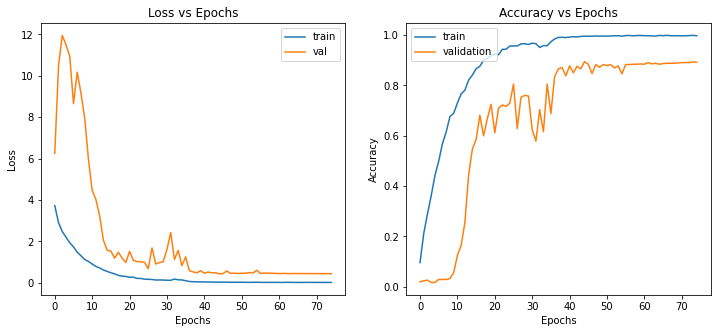

In [18]:
plot_metrics(h2)

In [19]:
#model_mfcc_1.save('mfcc_model_1.h5')
#model_mfcc_2.save('mfcc_model_2_vedanth.h5')

**Testing models**

In [20]:
mfcc_test_data_cat = np.load('../input/test-data-esc-50/mfcc_test_data_cat.npy',allow_pickle=True)

In [21]:
x_test_mfcc = np.zeros((1,20,216))
for i in tqdm(range(200)):
    x_test_mfcc = np.append(x_test_mfcc,[mfcc_test_data_cat[i][0][:,:,-1]],axis=0)

100%|██████████| 200/200 [00:00<00:00, 2891.91it/s]


In [22]:
x_test_mfcc = x_test_mfcc[1:,:,:]

In [23]:
x_test_mfcc = x_test_mfcc[:,:,:,np.newaxis]

In [24]:
y_test_mfcc = []
for i in range(200):
    y_test_mfcc.append(mfcc_test_data_cat[i][1])

In [25]:
y_test_mfcc = np.array(y_test_mfcc)

In [26]:
len(y_test_mfcc)

200

In [27]:
#Model Testing
results = model_mfcc_2.evaluate(x_test_mfcc, y_test_mfcc, batch_size=32)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 10ms/step - loss: 0.8573 - accuracy: 0.8050
test loss, test acc: [0.8573452830314636, 0.8050000071525574]
